# Oort parameters & SF

In [178]:
import numpy as np
import os
from IPython.display import Image
from scipy import stats
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import Cutout2D
import astropy.units as u
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [179]:
import functions

In [180]:
Distance = 9.3 # Mpc
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
sini = np.sin(incl / 180. * np.pi)

In [181]:
sigma_s = np.load('./data/sigma_s.npy')
Sigma_H2 = np.load('./data/Sigma_H2.npy')
sigma_HI = np.load('./data/sigma_HI.npy')
Sigma_HI = np.load('./data/Sigma_HI.npy')
Sigma_s = np.load('./data/Sigma_s.npy')
Sigma_SFR = np.load('./data/Sigma_SFR.npy')
sig_R_max = np.load('./data/sig_R_max.npy')
sig_R_min = np.load('./data/sig_R_min.npy')
r_HI = np.load('./data/r_HI.npy')
vel_HI = np.load('./data/vel_HI.npy')
r_HI_old = np.load('./data/r_HI_old.npy')
vel_HI_old = np.load('./data/vel_HI_old.npy')
velocity_HI = np.load('./data/velocity_HI.npy')
kappa = np.load('./data/kappa.npy')
dist_kpc = np.load('./data/dist_kpc_corr.npy')
sig_R_min_err = np.load('./data/sig_R_min_err.npy')
sig_R_max_err = np.load('./data/sig_R_max_err.npy')
sigma_s_err = np.load('./data/sigma_s_err.npy')
H_alpha = np.load('./data/H_alpha.npy')
Z = np.load('./data/Z.npy')

In [182]:
velocity_approx = poly1d(polyfit(r_HI, vel_HI, deg=4))

In [183]:
G = 4.32
Sigma_crit = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
 
        A = 0.5 * (velocity_approx(dist_kpc[i][j]) / dist_kpc[i][j] - velocity_approx.deriv()(dist_kpc[i][j]))  
        sigma_g = sigma_HI[i][j]/1000.
  
        Sigma_crit[i][j] = 0.4 * A * sigma_g / np.pi / G
    
Sigma_gas = 1.36 * (Sigma_HI + Sigma_H2)    

## The effect of differential rotation (using the two Oort parameters A and B )

[статья](https://arxiv.org/pdf/2003.02848.pdf)

$$\log{\Sigma_{SFR}} \propto \log{ 2 A^2 + 5 B^2}$$

$$A = | -0.5 \left( \dfrac{v(r_{gal})}{r_{gal}} - \dfrac{dv(r_{gal})}{dr_{gal}} \right) |$$
$$B = | -0.5 \left( \dfrac{v(r_{gal})}{r_{gal}} + \dfrac{dv(r_{gal})}{dr_{gal}} \right) |$$

In [184]:
def azimuthal_average(Q, step=None, vmax=None, maxval=None, vmin=0.1):
    az_av = []
    az_dev = []
    anulli = []
    for dbin in np.arange(vmin,vmax,step):
        mask = (dist_kpc >= dbin) & (dist_kpc <= dbin + step)
        anulli = Q[mask]
        mask = (anulli < maxval) & (anulli > 0.) 
        anulli = anulli[mask]
        az_av.append(anulli.sum()/mask.sum())
        az_dev.append(np.std(anulli))
    return az_av, az_dev

In [185]:
R = np.array(np.linspace(0.1,9.1,90))
A = [0.5 * (velocity_approx(dist) / dist - velocity_approx.deriv()(dist)) for dist in R]
B = [-0.5 * (velocity_approx(dist) / dist + velocity_approx.deriv()(dist)) for dist in R]
Sigma_SFR_az = azimuthal_average(Sigma_SFR, step=0.1, vmax=9.1, maxval = 5.)[0]


diff_rot = [2 * A[i]**2 + 5 * B[i]**2 for i in range(len(R))] 

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/home/lera/.local/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lera/.local/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/lera/.local/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'Galactocentric Radius [kpc]')

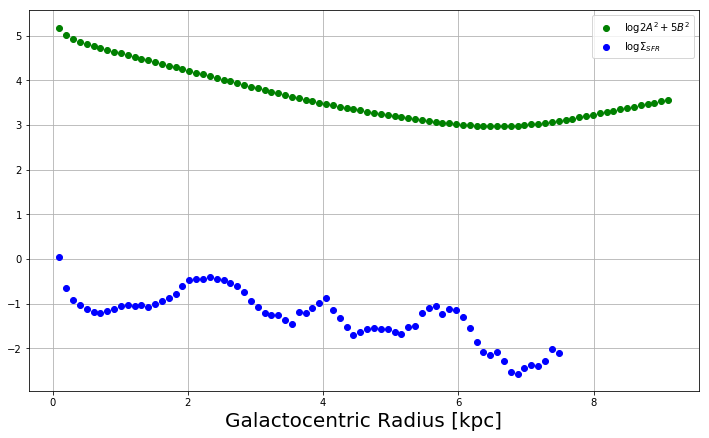

In [186]:
fig = plt.figure(figsize=[12, 7])
plt.plot(R, np.log10(diff_rot), 'o', lw=1, color='g',label=r'$\log{ 2 A^2 + 5 B^2}$')
plt.plot(R, np.log10(Sigma_SFR_az), 'o', lw=1, color='b',label=r'$\log{\Sigma_{SFR}}$')
plt.grid()
plt.legend()
plt.xlabel(r'Galactocentric Radius [kpc]', fontsize = 20)


In [187]:
from scipy import stats


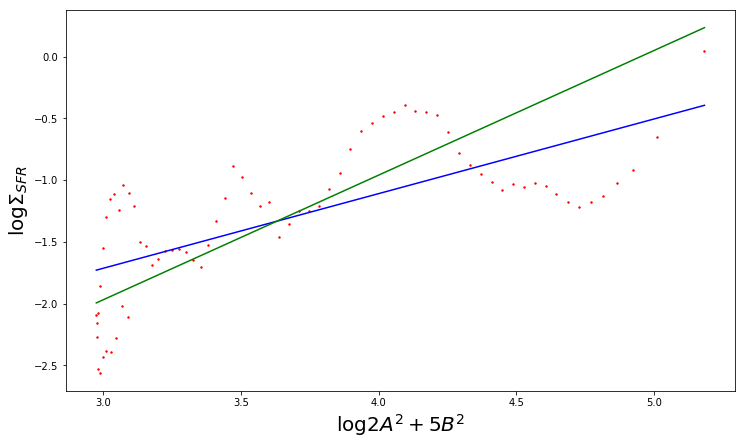

0.60 -3.53


In [188]:
x=np.log10(diff_rot[0:-16])
y=np.log10(Sigma_SFR_az[0:-16])
fig = plt.figure(figsize=[12, 7])
plt.scatter(x,y, 2., color='r')

gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
gradient1=1.01  # взяла из статьи
intercept1 = -5. # подобрала
x1=np.array(np.linspace(mn,mx,100))
y1=x1*gradient+intercept
x2=np.array(np.linspace(mn,mx,100))
y2=x2*gradient1+intercept1
plt.plot(x1,y1,'-',color='b')
plt.plot(x2,y2,'-',color='g')

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=20)
plt.xlabel(r'$\log{2 A^2 + 5 B^2}$',fontsize=20)
plt.show()
print('{:2.2f}'.format(gradient),'{:2.2f}'.format(intercept))

$$\log{\Sigma_{SFR}} = -3.53 + 0.60\times \log{( 2 A^2 + 5 B^2)}$$



In [189]:
Diff_rot = np.zeros(dist_kpc.shape)
A_2d = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
 
        A_2d[i][j] = 0.5 * (velocity_approx(dist_kpc[i][j]) / dist_kpc[i][j] - velocity_approx.deriv()(dist_kpc[i][j]))
        B = -0.5 * (velocity_approx(dist_kpc[i][j]) / dist_kpc[i][j] + velocity_approx.deriv()(dist_kpc[i][j])) 
         
        Diff_rot[i][j] =2 * A_2d[i][j]**2 + 5 * B**2

In [190]:
try:
    from astropy.convolution import Gaussian2DKernel, convolve
    astro_smooth = True
except ImportError as IE:
    astro_smooth = False

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


0.7524286159619595 -4.271570792257311


/home/lera/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


Text(0.5, 0, '$\\log{2 A^2 + 5 B^2}$')

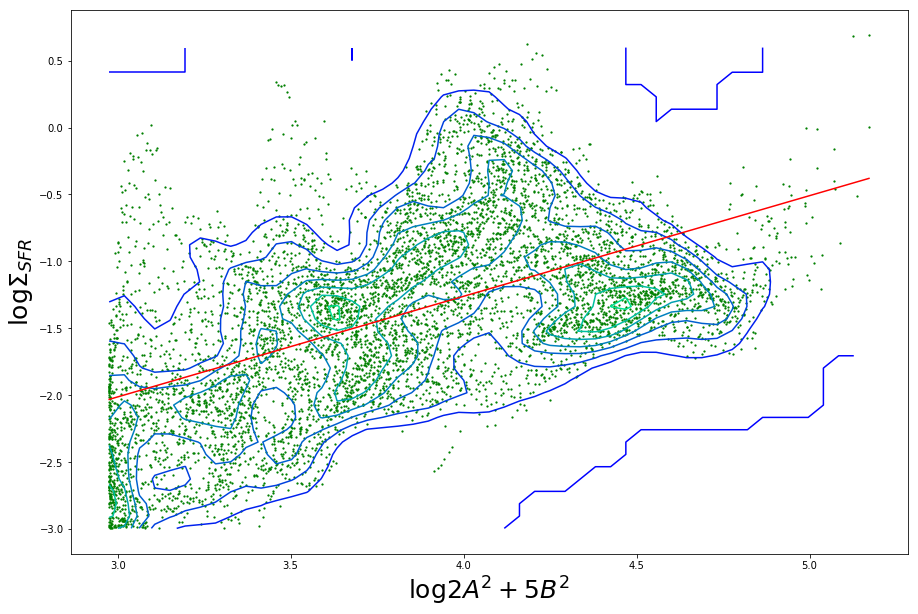

In [191]:
fig = plt.figure(figsize=[15,10])
indxs = (Sigma_SFR != nan) & (Diff_rot != 0) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)
y,x = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(Diff_rot[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)

#indxs1 =  (x <= 2.9) & (-3 <= y < 0)
#y1,x1 = np.ravel(y[indxs1]), np.ravel(x[indxs1])
                                                                                                         
#x1=np.nan_to_num(x1)
#y1=np.nan_to_num(y1)

#indxs2 = (Sigma_SFR != nan) & (Diff_rot != 0) & (dist_kpc > 0.1) & (3.2 <= np.log10(Diff_rot) <= 3.4) & (-1 <= np.log10(Sigma_SFR) < 0.5)                  
#y2,x2 = np.ravel(np.log10(Sigma_SFR)[indxs2]), np.log10(np.ravel(Diff_rot[indxs2]))

#x2=np.nan_to_num(x2)
#y2=np.nan_to_num(y2)

#indxs3 = (Sigma_SFR != nan) & (Diff_rot != 0) & (dist_kpc > 0.1) & (3.85 <= np.log10(Diff_rot) <= 4.5) & (-0.75 <= np.log10(Sigma_SFR) < 0.5)
#y3,x3 = np.ravel(np.log10(Sigma_SFR)[indxs3]), np.log10(np.ravel(Diff_rot[indxs3]))

#x3=np.nan_to_num(x3)
#y3=np.nan_to_num(y3)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1.5, color='g')
#plt.scatter(x1,y1, 1., color='r')
#plt.scatter(x2,y2, 1., color='purple')
#plt.scatter(x3,y3, 1., color='b')
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x1,y1,'-r')
print(gradient,intercept)

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.xlabel(r'$\log{2 A^2 + 5 B^2}$',fontsize=25)
#plt.ylim(0.,2.5)
#plt.xlim(-3,0.5)



$$\log{\Sigma_{SFR}} = -4.27 + 0.75\times \log{( 2 A^2 + 5 B^2)}$$



Выделим некоторые области на графике и поймём, где они располагаются на карте:

In [192]:
fields = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        
        if(3. < np.log10(Diff_rot[i][j]) <= 3.35) & (-1 <= np.log10(Sigma_SFR[i][j]) < 0.2):
            fields[i][j] = 1
        
        elif(3.4 <= np.log10(Diff_rot[i][j]) <= 3.75) & (-0.75 <= np.log10(Sigma_SFR[i][j]) < 0.5):
            fields[i][j] = 2
            
        elif(3.8 <= np.log10(Diff_rot[i][j]) <= 4.5) & (-0.75 <= np.log10(Sigma_SFR[i][j]) < 0.5):
            fields[i][j] = 3    

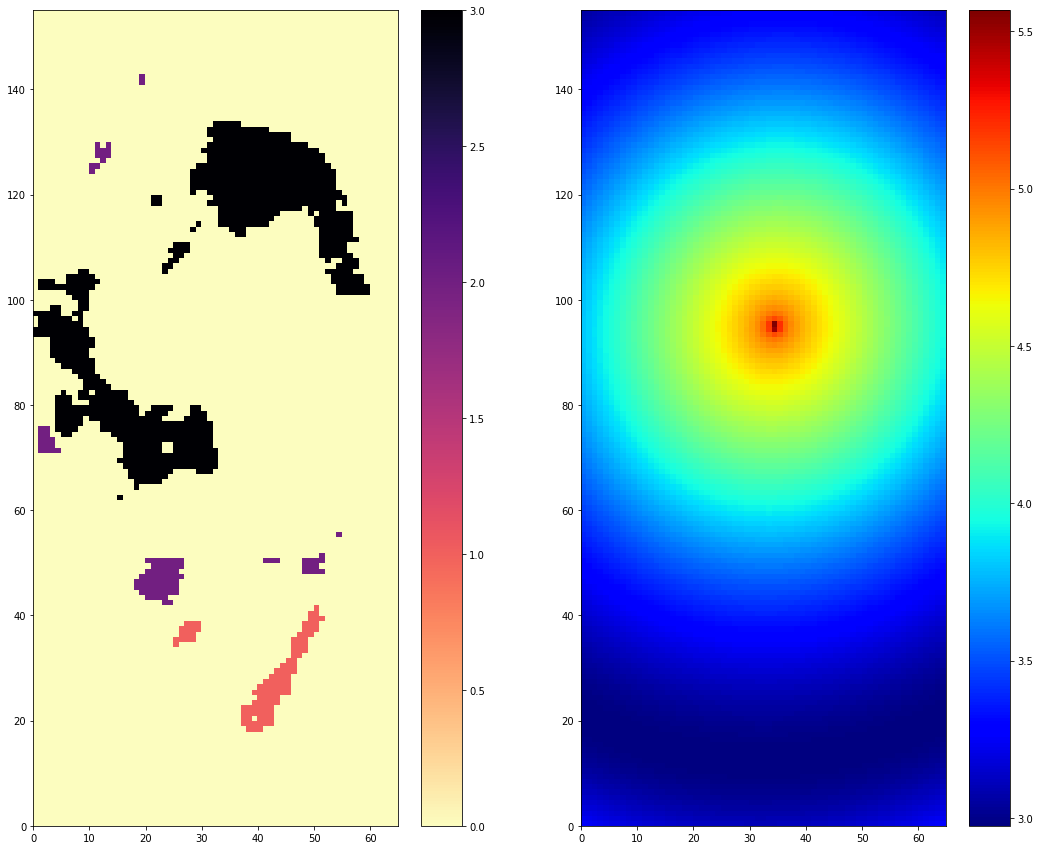

In [193]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[18,15])
plt.subplot(1,2,1)
#CS = plt.contour(X, Y, Sigma_SFR, levels=[0.032,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, fields, cmap='magma_r')
#quadmesh.set_clim(vmin=0., vmax = 10)
plt.colorbar()

plt.subplot(1,2,2)
#CS = plt.contour(X, Y, Sigma_SFR, levels=[0.032,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, np.log10(Diff_rot), cmap='jet')
#quadmesh.set_clim(vmin=0., vmax = 10)
plt.colorbar()

Выделим на картинке спирали области со спиралями.

/home/lera/.local/lib/python3.5/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


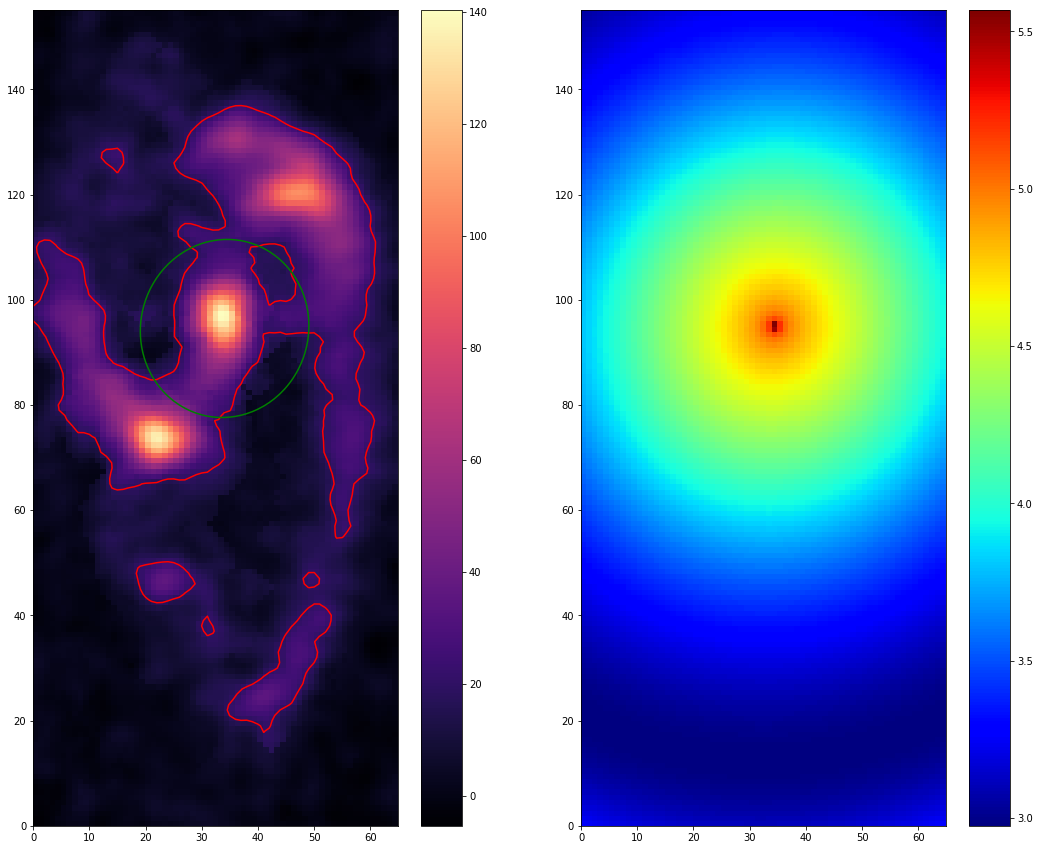

In [194]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[18,15])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, Sigma_H2, levels=[20,], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, dist_kpc, levels=[0,1.35], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y,Sigma_H2, cmap='magma')
#quadmesh.set_clim(vmin=0., vmax = 4000)
plt.colorbar()

plt.subplot(1,2,2)
#CS = plt.contour(X, Y, Sigma_SFR, levels=[0.032,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, np.log10(Diff_rot), cmap='jet')
#quadmesh.set_clim(vmin=0., vmax = 10)
plt.colorbar()

0.7524286159619595 -4.271570792257311


/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


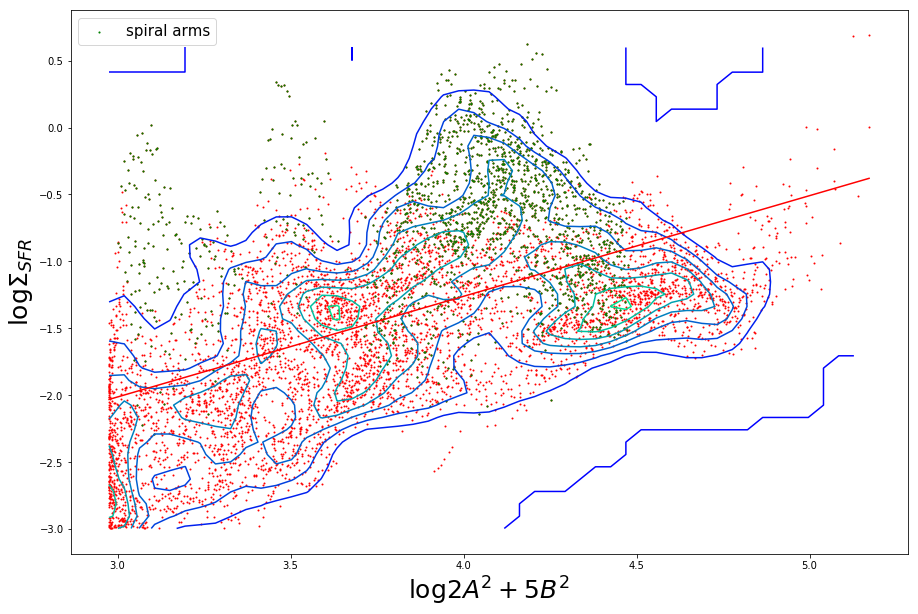

In [195]:
fig = plt.figure(figsize=[15,10])
indxs = (Sigma_SFR != nan) & (Diff_rot != 0) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)

y,x = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(Diff_rot[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)

indxs1 = indxs & (1.35 < dist_kpc) & (Sigma_H2>20)

y_,x_ = np.ravel(np.log10(Sigma_SFR)[indxs1]), np.log10(np.ravel(Diff_rot[indxs1]))

x_=np.nan_to_num(x_)
y_=np.nan_to_num(y_)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

plt.scatter(x_,y_, 1.2, color='g',label = 'spiral arms')

gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x1,y1,'-r')
print(gradient,intercept)

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.xlabel(r'$\log{2 A^2 + 5 B^2}$',fontsize=25)
plt.legend(fontsize = 15)

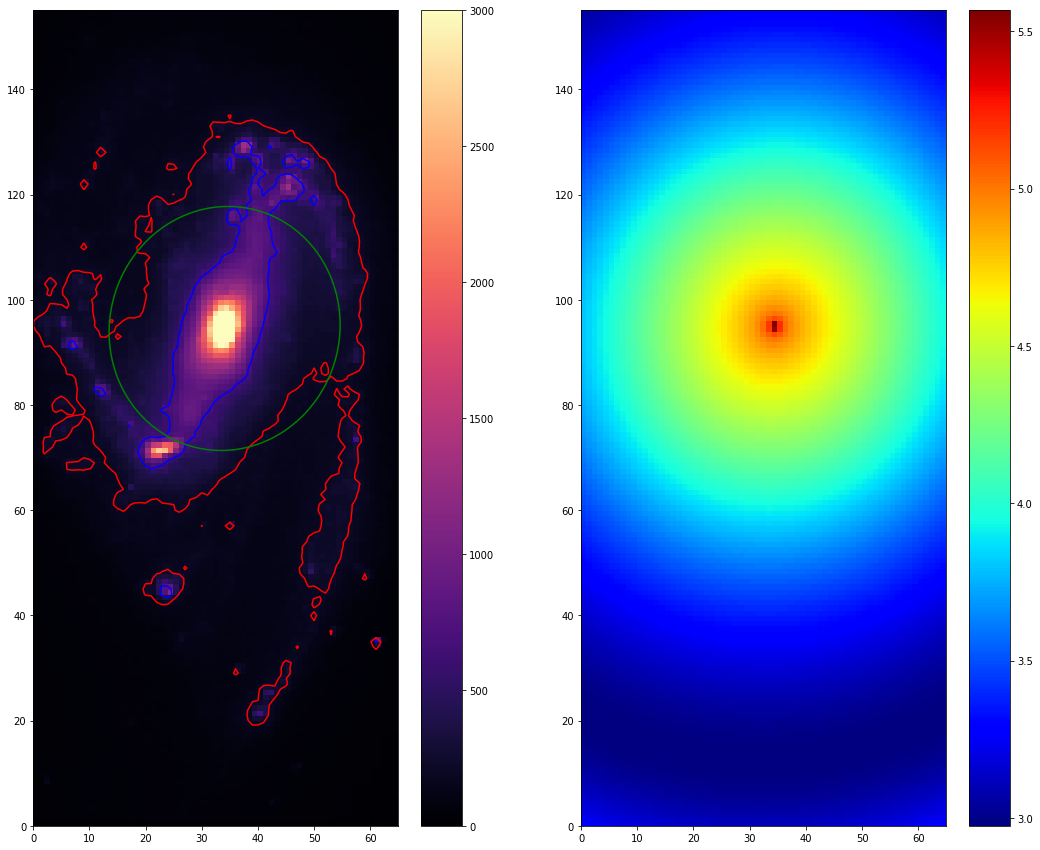

In [196]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
fig = plt.figure(figsize=[18,15])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, Sigma_s, levels=[200,], aspect='auto', alpha=1, colors='red')
CS = plt.contour(X, Y, Sigma_s, levels=[650,], aspect='auto', alpha=1, colors='blue')
CS = plt.contour(X, Y, dist_kpc, levels=[0,1.85], aspect='auto', alpha=1, colors='green')
quadmesh = plt.pcolormesh(X, Y,Sigma_s, cmap='magma')
quadmesh.set_clim(vmin=0., vmax = 3000)
plt.colorbar()

plt.subplot(1,2,2)
#CS = plt.contour(X, Y, Sigma_SFR, levels=[0.032,], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, np.log10(Diff_rot), cmap='jet')
#quadmesh.set_clim(vmin=0., vmax = 10)
plt.colorbar()

0.7524286159619595 -4.271570792257311


/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


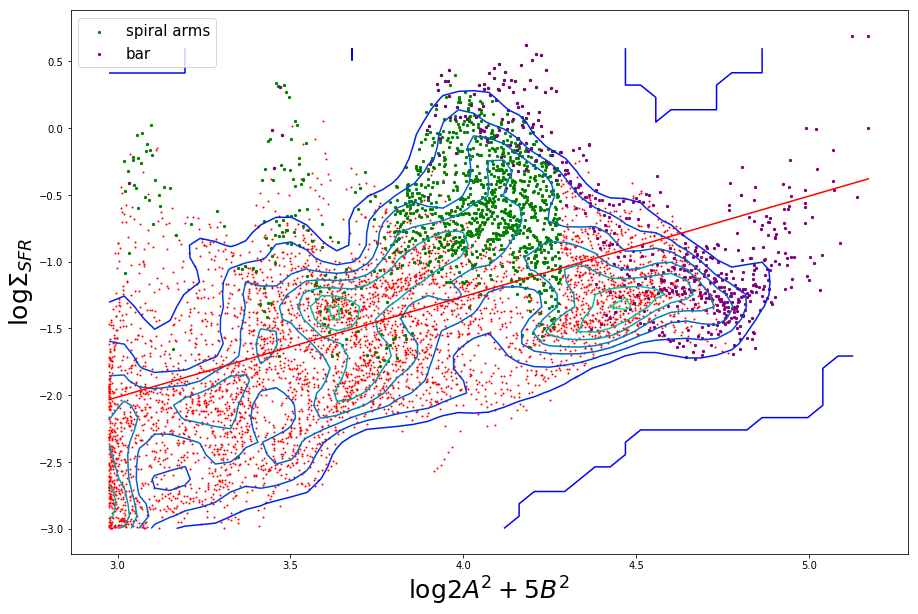

In [197]:
fig = plt.figure(figsize=[15,10])
indxs = (Sigma_SFR != nan) & (Diff_rot != 0) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)

y,x = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(Diff_rot[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)

indxs1 = indxs & (1.85 < dist_kpc) & (Sigma_s>200)

y_,x_ = np.ravel(np.log10(Sigma_SFR)[indxs1]), np.log10(np.ravel(Diff_rot[indxs1]))

x_=np.nan_to_num(x_)
y_=np.nan_to_num(y_)

indxs2 = indxs & (Sigma_s>650)

y__,x__ = np.ravel(np.log10(Sigma_SFR)[indxs2]), np.log10(np.ravel(Diff_rot[indxs2]))

x__=np.nan_to_num(x__)
y__=np.nan_to_num(y__)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

plt.scatter(x_,y_, 5, color='g',label = 'spiral arms')

plt.scatter(x__,y__, 5, color='purple',label = 'bar')

gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x1,y1,'-r')
print(gradient,intercept)

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.xlabel(r'$\log{2 A^2 + 5 B^2}$',fontsize=25)
plt.legend(fontsize = 15)

Разберёмся с вопросом про shear & $\Sigma_{SFR}$

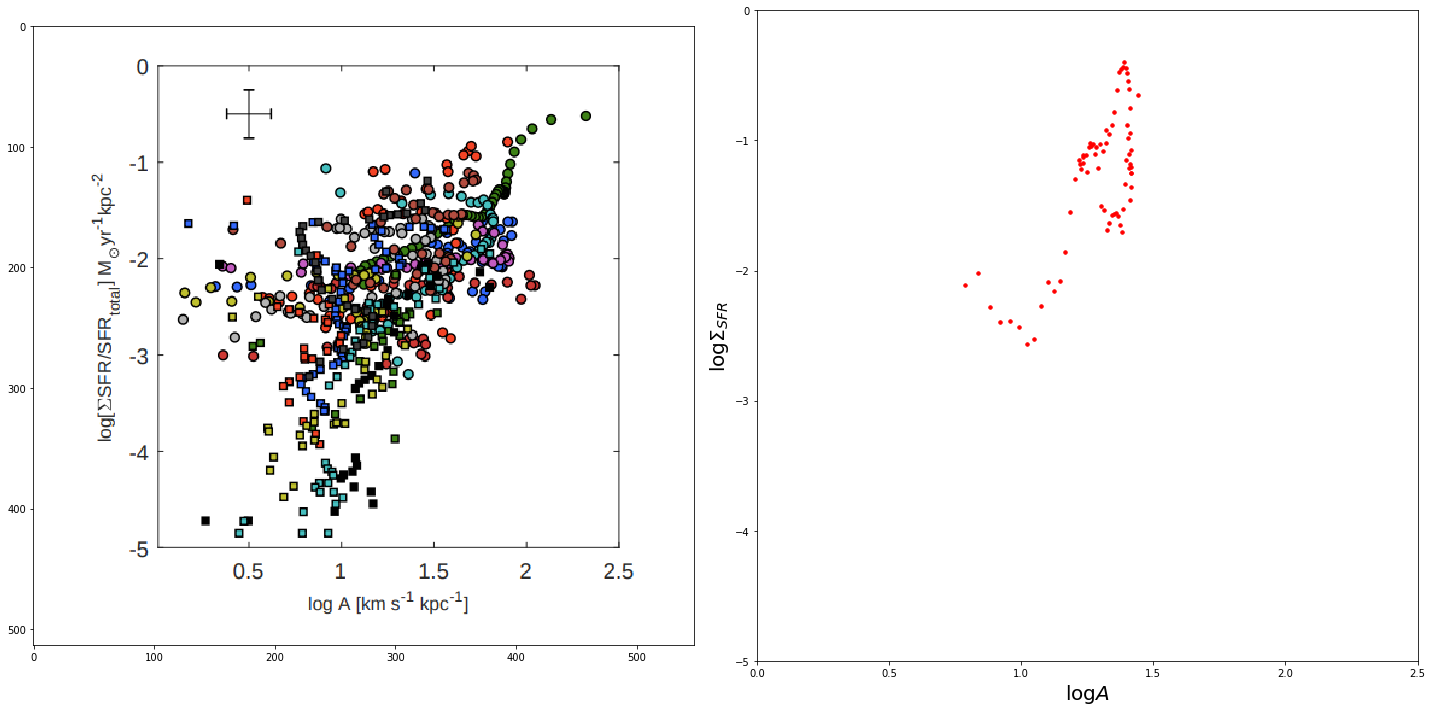

In [198]:
from PIL import Image as Im
x=np.log10(A[0:-9])
y=np.log10(Sigma_SFR_az[0:-9])
fig, axes = plt.subplots(1, 2,figsize=[20, 10])
axes[0].imshow(Im.open('./images/A&SFR.png'))
#axes[0].set_xticks([])
#ylim(0,2.5)axes[0].set_yticks([])
axes[1].scatter(x,y, 12., color='r')
axes[1].set_ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=20)
axes[1].set_xlabel(r'$\log{A}$',fontsize=20)
axes[1].set_ylim(-5,0)
axes[1].set_xlim(0,2.5)
plt.tight_layout()
plt.show()


/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


(-3, 0.8784440992934279)

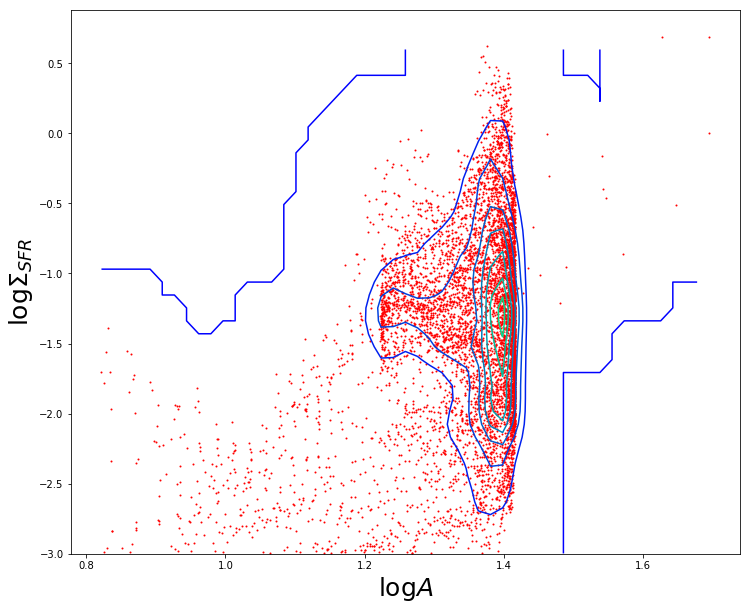

In [199]:
fig = plt.figure(figsize=[12,10])
indxs = (Sigma_SFR != nan) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)

y,x = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(A_2d[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

#gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#mn=np.min(x)
#mx=np.max(x)
#x1=np.linspace(mn,mx,500)
#y1=gradient*x1+intercept
#plt.plot(x1,y1,'-r')
#print(gradient,intercept)

plt.ylabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.xlabel(r'$\log{A}$',fontsize=25)
#plt.xlim(0,1.5)
plt.ylim(-3,)

nan nan


/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, '$\\log{\\Sigma_{gas}/\\Sigma_{crit}}$')

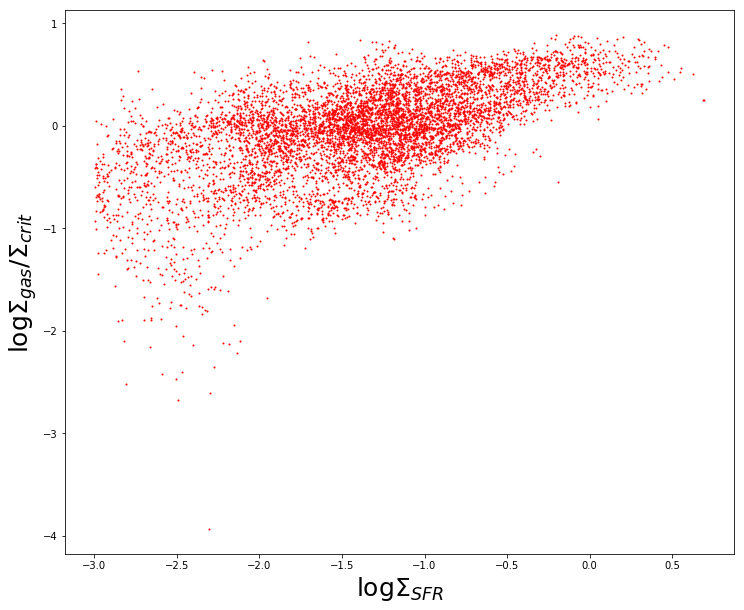

In [211]:
fig = plt.figure(figsize=[12,10])
shear_method = Sigma_gas/Sigma_crit
indxs = (Sigma_SFR != nan) & (shear_method > 0) & (Sigma_SFR != 0) & (dist_kpc > 0.1) & (np.log10(Sigma_SFR)>-3)

x,y = np.ravel(np.log10(Sigma_SFR)[indxs]), np.log10(np.ravel(shear_method[indxs]))

x=np.nan_to_num(x)
y=np.nan_to_num(y)


H, xedges, yedges = np.histogram2d(x,y, bins=(50,40))
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
# Smooth the contours (if astropy is installed)
if astro_smooth:
    kernel = Gaussian2DKernel(stddev=1.)
    H=convolve(H,kernel)
    
#clevels = plt.contour(xmesh,ymesh,H.T,lw=.9,cmap='winter')#,zorder=90)
plt.scatter(x,y, 1., color='r')

gradient, intercept, r_value, p_value, std_err = stats.linregress(y,x)
mn=np.min(x)
mx=np.max(x)
#gradient = 0.87
#intercept = 2.
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x1,y1,'-',color='r')
print(gradient,intercept)

plt.xlabel(r'$\log{\Sigma_{SFR}}$',fontsize=25)
plt.ylabel(r'$\log{\Sigma_{gas}/\Sigma_{crit}}$',fontsize=25)
#plt.ylim(-2.5,3)
#plt.xlim(-3,)

### Вычислим круговую скорость:

воспользуемся формулой 1 из [статьи](https://arxiv.org/pdf/astro-ph/0103507.pdf)

$$V^{mod1}(r,\phi) = V_s^{mod1} + V_{rot}^{mod1} cos\phi sin i$$

In [173]:
vel_los = np.load('./data/vel_los.npy')
phi = np.load('./data/phi.npy')

In [174]:
vel_circle = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        if (89< phi[i][j] < 91):
            vel_circle[i][j] = (vel_los[i][j]/1000.-717.2)/sini
        else:
            vel_circle[i][j] = (vel_los[i][j]/1000.-717.2)/sini/np.cos(phi[i][j] / 180. * np.pi)

Text(0.5, 1.0, 'circle velocity')

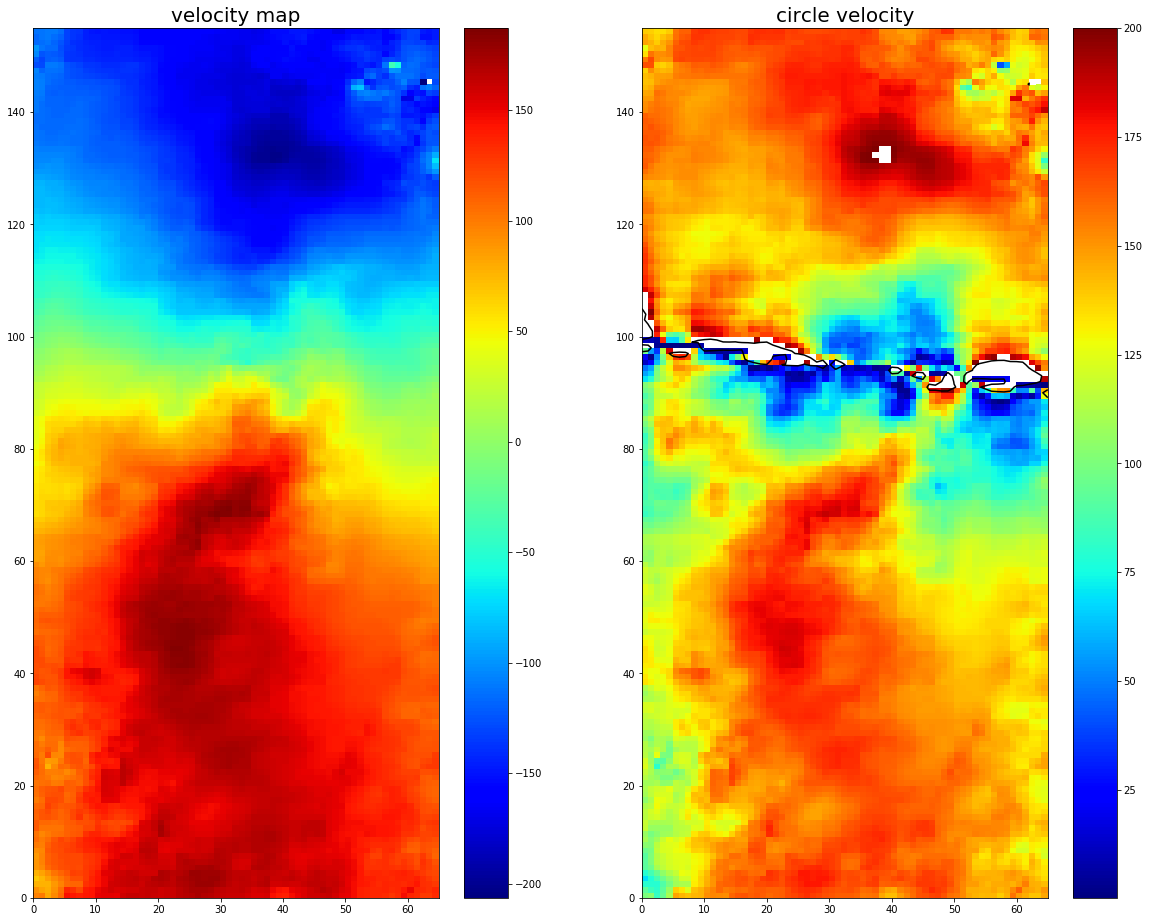

In [175]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[20, 16])
plt.subplot(1,2,1)

quadmesh = plt.pcolormesh(X, Y, (vel_los/1000.-717.2)/sini, cmap='jet')
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'velocity map', fontsize=20)

plt.subplot(1,2,2)

CS = plt.contour(X, Y, np.abs(vel_circle), levels=[210,],aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, np.abs(vel_circle), cmap='jet')
quadmesh.cmap.set_under('white')
quadmesh.set_clim(vmax = 200)
plt.colorbar()
plt.title(r'circle velocity', fontsize=20)

### Получим residuals

In [176]:
residuals = np.zeros(dist_kpc.shape)
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        residuals[i][j] = np.abs(vel_circle[i][j]) - velocity_approx(dist_kpc[i][j])

Text(0.5, 1.0, 'residuals')

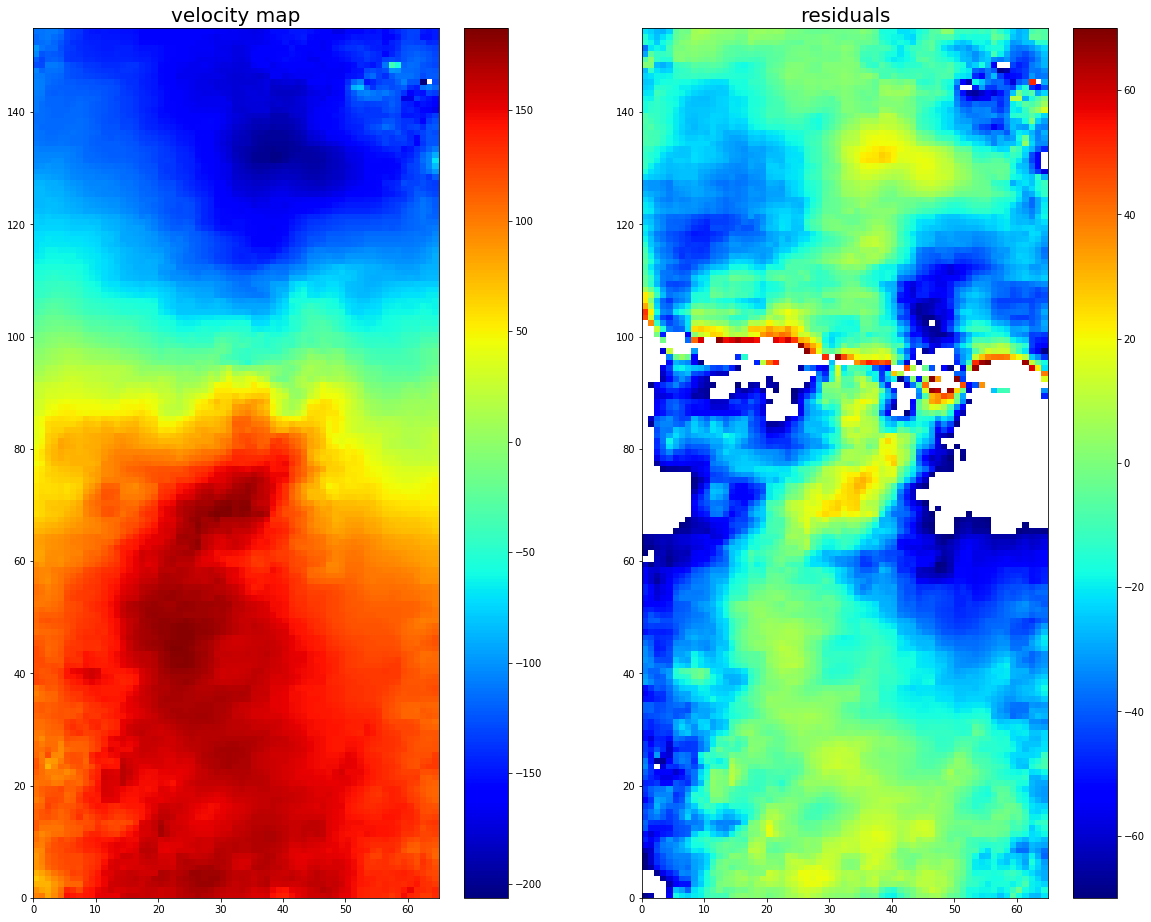

In [177]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[20, 16])
plt.subplot(1,2,1)

quadmesh = plt.pcolormesh(X, Y, (vel_los/1000.-717.2)/sini, cmap='jet')
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'velocity map', fontsize=20)

plt.subplot(1,2,2)

#CS = plt.contour(X, Y, np.abs(vel_circle), levels=[210,],aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, residuals, cmap='jet')
quadmesh.cmap.set_under('white')
quadmesh.set_clim(vmin=-70,vmax = 70)
plt.colorbar()
plt.title(r'residuals', fontsize=20)

### Сделаем то же самое только для полной карты


In [74]:
data=fits.getdata('./data/NGC_3627_NA_MOM1_THINGS.FITS')             
data = np.squeeze(data)
data_WCS = WCS('./data/NGC_3627_NA_MOM1_THINGS.FITS', naxis = 2)
print(data_WCS.wcs)
print(data.shape)

       flag: 137
      naxis: 2
      crpix: 0x140320d0
               512.00       513.00    
         pc: 0xc020370
    pc[0][]:   1.0000       0.0000    
    pc[1][]:  -0.0000       1.0000    
      cdelt: 0xf035f60
              -0.00041667   0.00041667
      crval: 0x56c51e0
               170.06       12.992    
      cunit: 0x13fcf200
             "deg"
             "deg"
      ctype: 0x174be3e0
             "RA---SIN"
             "DEC--SIN"
    lonpole: 180.000000
    latpole: 12.991528
    restfrq: 1420405750.000000
    restwav: 0.000000
        npv: 0
     npvmax: 64
         pv: 0x1402a580
        nps: 0
     npsmax: 8
         ps: 0xc021cd0
         cd: 0xc0203a0
    cd[0][]:   0.0000       0.0000    
    cd[1][]:   0.0000       0.0000    
      crota: 0xefd46c0
               0.0000       0.0000    
     altlin: 4
     velref: 2
        alt: ' '
     colnum: 0
      colax: 0x13f05cf0
                 0      0
    wcsname: UNDEFINED
      cname: 0x13ffe2a0
             UND

In [92]:
size= [700,620]
cposition= SkyCoord('170.06205 12.9917', frame='icrs', unit='deg', equinox='J2000.0')
size = u.Quantity(size, u.arcsec)
data_ = Cutout2D(data, cposition, size, wcs=data_WCS, mode='partial', fill_value=0.)
print(data_.shape)
cpixel = skycoord_to_pixel(cposition,data_.wcs)
print(cpixel)

(467, 413)
(array(206.23506106), array(233.40506933))


In [93]:
206. - 233. * np.tan(7.*np.pi/180.)

177.39119730962324

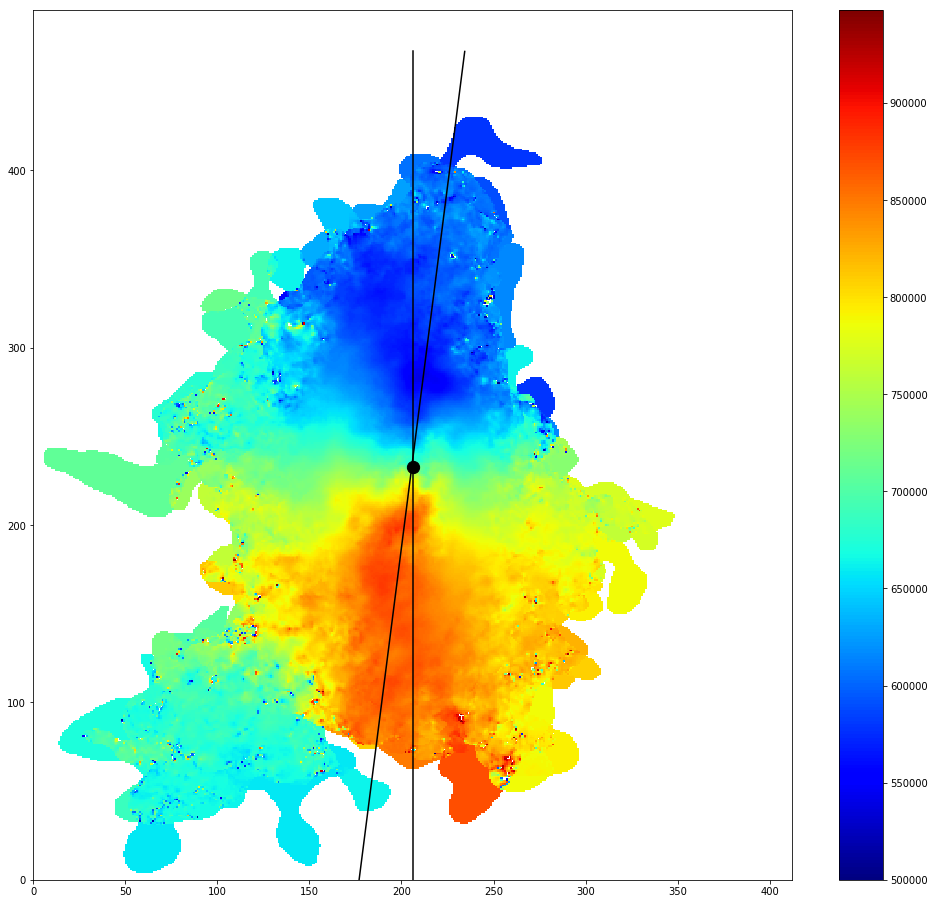

In [95]:
X,Y = np.meshgrid(np.arange(0.,413,1), np.arange(0.,467,1))

plt.figure(figsize=[17,16])
quadmesh = plt.pcolormesh(X, Y, data_.data, cmap=cm.jet)
plt.colorbar()
plt.scatter(206 ,233,[150.], color='black' )
plt.plot([206 ,206 ], [0.,467.], color='black')
plt.plot([177,177 + 467. * np.tan(7.*np.pi/180)], [0., 467], color='black')

In [28]:
def angles(V1,U1,V2,U2,V3,U3):
    c = (V3-V1)**2 + (U3-U1)**2
    a = (V2-V1)**2 + (U2-U1)**2
    b = (V3-V2)**2 + (U3-U2)**2
    
    cos = (c-a-b)  / 2 / np.sqrt(a) / np.sqrt(b)
    return np.arccos(cos)

In [96]:
phi_full = np.zeros((467,413))

for i in range(413):
    for j in range(467):
        phi_full[j][i] = angles(i,j,206 ,233,177,0.)*180./np.pi
        
      

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


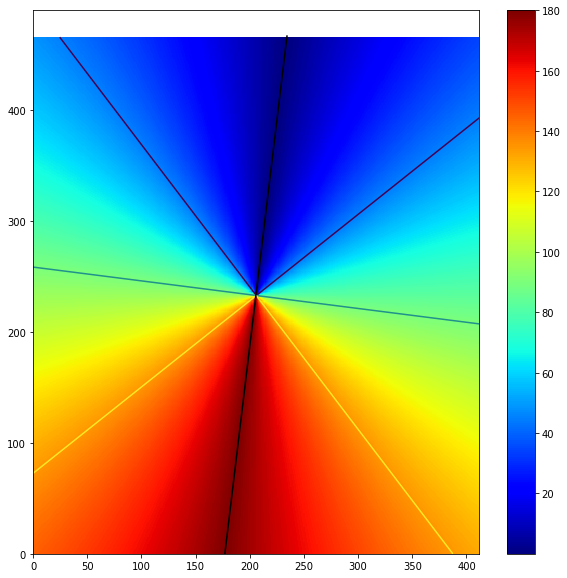

In [97]:
X,Y = np.meshgrid(np.arange(0.,413,1), np.arange(0.,467,1))

plt.figure(figsize=[10, 10])
quadmesh = plt.pcolormesh(X, Y, phi_full, cmap=cm.jet)
# quadmesh.set_clim(vmin=6.0, vmax=80.)
plt.colorbar()
quadmesh.cmap.set_under('white')
quadmesh.cmap.set_over('white')

CS = plt.contour(X, Y, phi_full, levels=[45., 90., 135.], aspect='auto')

plt.plot([177,177 + 467 * np.tan(7.*np.pi/180)], [0., 467], color='black')

In [99]:
cposition= SkyCoord('170.06205 12.9917', frame='icrs', unit='deg', equinox='J2000.0')

shape = data_.shape
X, Y = np.meshgrid(np.arange(0, shape[1], 1), np.arange(0, shape[0], 1))
sgrid = pixel_to_skycoord(X.ravel(), Y.ravel(), data_.wcs).reshape((shape[0], shape[1]))

dist_ = np.zeros((467,413))
for i in range(len(dist_)):
    for j in range(len(dist_[0])):
        scoord = sgrid[i][j]
        dist_[i][j] = cposition.separation(scoord).arcsec

In [100]:
dist_kpc_ = dist_ * np.pi / (180 *3600) * Distance * 10**3
dist_kpc_full = np.sqrt((dist_kpc_*np.cos(phi_full/180.*np.pi)*sini)**2 + (dist_kpc_*np.sin(phi_full/180.*np.pi))**2)    

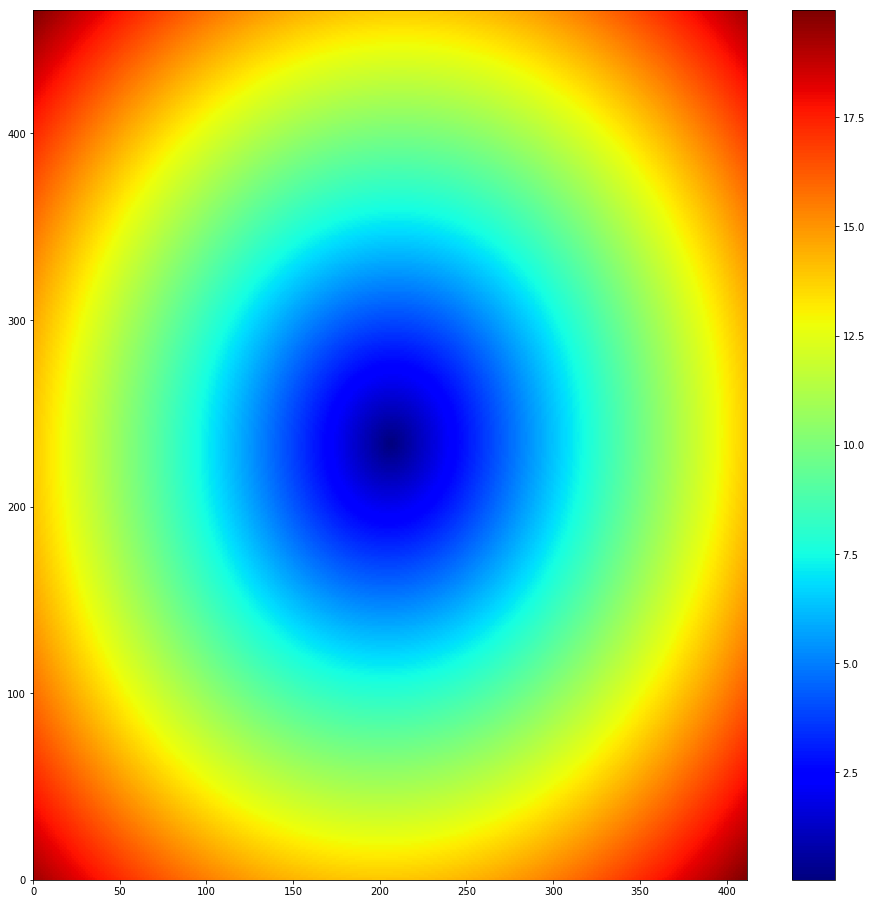

In [101]:
X,Y = np.meshgrid(np.arange(0.,413,1), np.arange(0.,467,1))
plt.figure(figsize=[16, 16])
quadmesh = plt.pcolormesh(X, Y, dist_kpc_full, cmap='jet')
plt.colorbar()


In [106]:
data_ = np.array(data_.data).reshape((467,413))

In [107]:
veloc_norm = lambda l: (l/1000. - 717.2)/sini
velocity_full= veloc_norm(data_)

In [108]:
np.save('./data/velocity_full.npy', velocity_full)
np.save('./data/dist_kpc_full.npy', dist_kpc_full)
np.save('./data/phi_full.npy',phi_full)

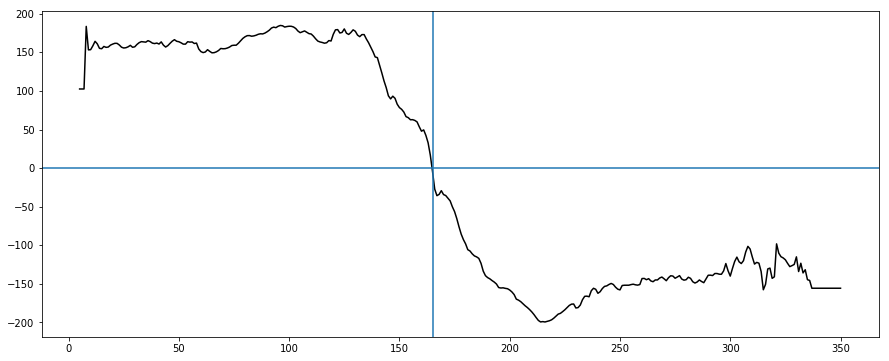

In [116]:
x0, y0 = 177, 70.  
x1, y1 = 177 + 467. * np.tan(7.*np.pi/180.),466.
num = 400
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
zi_cub = velocity_full[y.astype(np.int), x.astype(np.int)]

fig = plt.figure(figsize = [15, 6])
line = plot(zi_cub,'black')
plt.axhline(y = 0)
plt.axvline(x = 165)

In [ ]:
#Определим длину нашего среза
r_vel = np.sqrt(467.**2 + (467. * np.tan(7.*np.pi/180))**2)
#Переведём в arcsec
r_vel = r_vel * 1.9
#Найдём центр галактики на срезе
c_r_vel = 233 / math.cos(7.*np.pi/180.)
c_r_vel = c_r_vel * 1.9

In [120]:
r = np.zeros(num)
r = np.arange(num)
new_center = 165
v_at_new_center = 0.
old_center = 165

step=1
r_HI = np.zeros(num)
vel_HI = np.zeros(num)
r_HI_ = np.abs([d-new_center for d in r]) 
vel_HI = np.abs([zi_cub[i]- v_at_new_center if i<old_center else -v_at_new_center-abs(zi_cub[i]) for i in range(num)])
r_HI = r_HI_ * step * np.pi / (180 *3600) * Distance * 10**3 
print(len(r_HI), len(vel_HI))

400 400


In [138]:
r_HI_full = r_HI[5:-49]
vel_HI_full = vel_HI[5:-49]


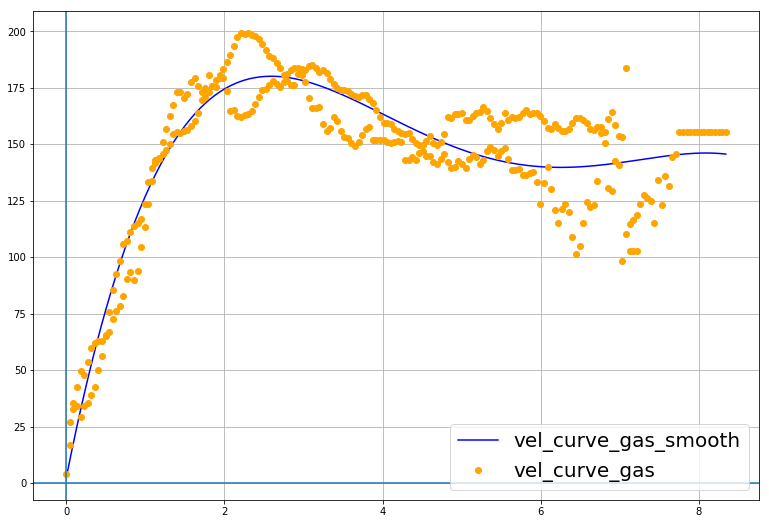

In [139]:
points1 = np.linspace(min(r_HI_full), max(r_HI_full), 400)
velocity_approx1 = poly1d(polyfit(r_HI_full, vel_HI_full, deg=4))

fig, ax = plt.subplots(figsize=[13,9])
line1 = ax.plot(points1, velocity_approx1(points1),color='blue', label='vel_curve_gas_smooth')
line3 = ax.plot(r_HI_full,vel_HI_full,'o',color='orange',label = 'vel_curve_gas')
plt.legend(loc='lower right',fontsize=20)
plt.grid()

plt.axhline(y =0.)
plt.axvline(x =0)

In [148]:
vel_circle_full = np.zeros(dist_kpc_full.shape)
for i, row in enumerate(dist_kpc_full):
    for j, col in enumerate(dist_kpc_full[0]):
        if (phi_full[i][j] == 90):
            vel_circle_full[i][j] = velocity_full[i][j]
        else:
            vel_circle_full[i][j] = velocity_full[i][j]/np.cos(phi_full[i][j] / 180. * np.pi)

Text(0.5, 1.0, 'circle velocity')

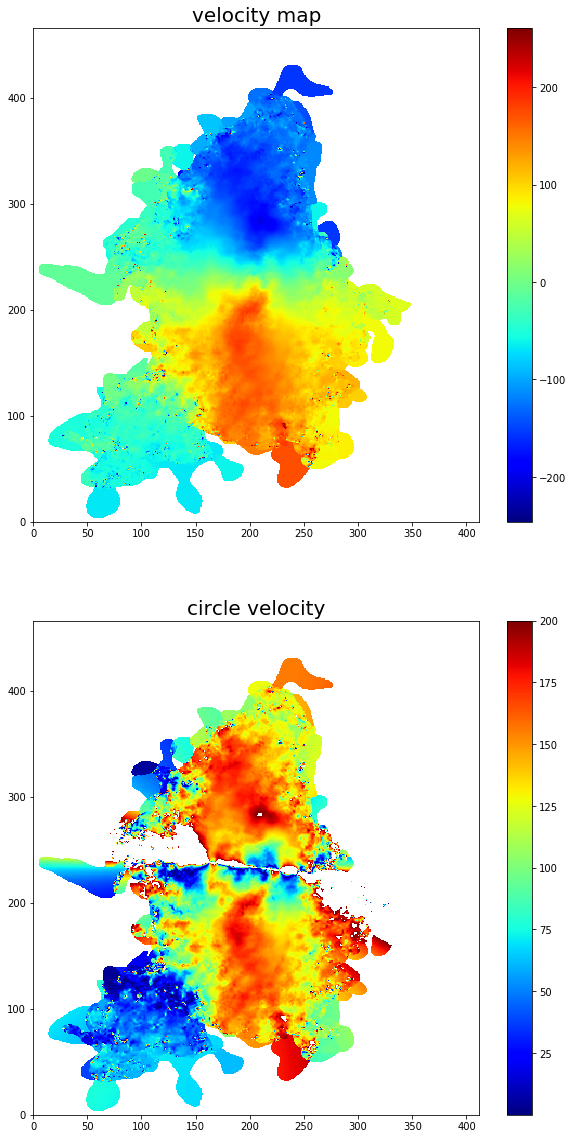

In [150]:
X,Y = np.meshgrid(np.arange(0.,413,1), np.arange(0.,467,1))
plt.figure(figsize=[10, 20])
plt.subplot(2,1,1)

quadmesh = plt.pcolormesh(X, Y, velocity_full, cmap='jet')
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'velocity map', fontsize=20)

plt.subplot(2,1,2)

#CS = plt.contour(X, Y, np.abs(vel_circle_full), levels=[210,],aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, np.abs(vel_circle_full), cmap='jet')
quadmesh.cmap.set_under('white')
quadmesh.set_clim(vmax = 200)
plt.colorbar()
plt.title(r'circle velocity', fontsize=20)

### Получим residuals

In [146]:
residuals_full = np.zeros(dist_kpc_full.shape)
for i, row in enumerate(dist_kpc_full):
    for j, col in enumerate(dist_kpc_full[0]):
        residuals_full[i][j] = np.abs(vel_circle_full[i][j]) - velocity_approx1(dist_kpc_full[i][j])

Text(0.5, 1.0, 'residuals')

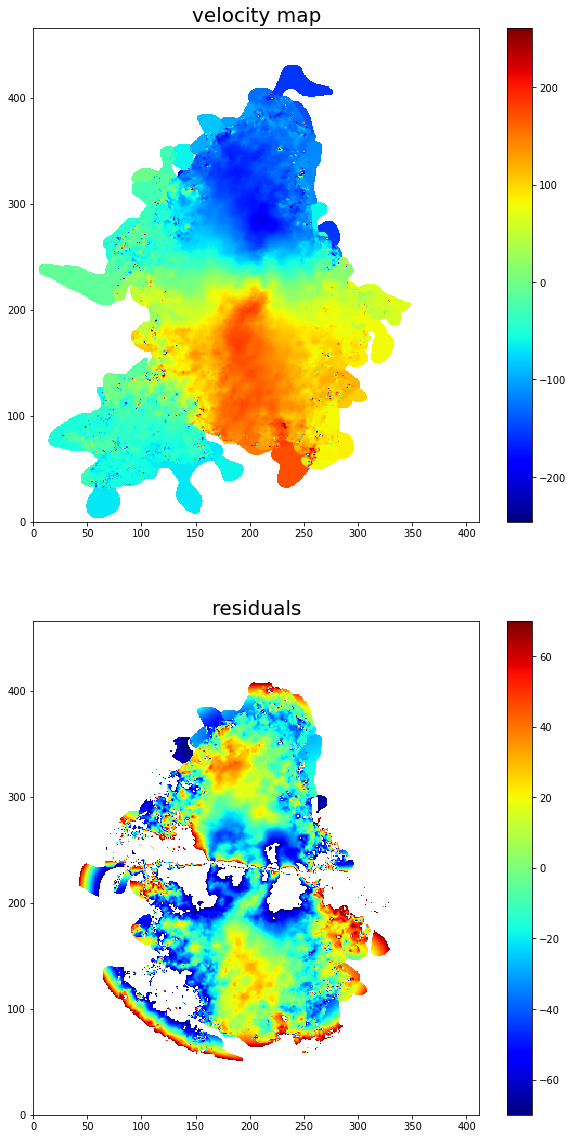

In [155]:
X,Y = np.meshgrid(np.arange(0.,413,1), np.arange(0.,467,1))
plt.figure(figsize=[10, 20])
plt.subplot(2,1,1)

quadmesh = plt.pcolormesh(X, Y, velocity_full, cmap='jet')
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'velocity map', fontsize=20)

plt.subplot(2,1,2)

#CS = plt.contour(X, Y, np.abs(vel_circle), levels=[210,],aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, residuals_full, cmap='jet')
quadmesh.cmap.set_under('white')
quadmesh.set_clim(vmin=-70,vmax = 70)
plt.colorbar()
plt.title(r'residuals', fontsize=20)